# NASLib Hands-On 2023

## Welcome to the [NASLib](https://github.com/automl/NASLib) tutorial on performance prediction

This notebook is part of the **NASLib Hands-On Session** for the [3rd AutoML Fall school](https://sites.google.com/view/automl-fall-school-2023). Before you start, please copy this notebook to your Google drive (`File` ➡ `Save a Copy in Drive`).

This Colab Notebook can be run without GPUs/TPUs, so you may choose "None" as the Hardware accelerator in `Runtime` ➡ `Change runtime type`


## NASLib Hands-On 2022
This tutorial is a sequel to the great tutorial by Arjun Krishnakumar and Rhea Sukthanker from [last year](https://sites.google.com/view/automl-fall-school-2022/schedule/hands-on-naslib). The focus was more on black-box optimization and search methods. You can find the previous notebook [here](https://colab.research.google.com/drive/1uEm5nw0wmAIWP97YzPloTKZA5DJXActL?usp=sharing)

# NASLib overview
NASLib is a modular and flexible framework created with the aim of providing a common codebase to the community to facilitate research on Neural Architecture Search (NAS). It offers high-level abstractions for designing and reusing search spaces, interfaces to benchmarks and evaluation pipelines, enabling the implementation and extension of several NAS methods with a few lines of code.

![](https://raw.githubusercontent.com/automl/NASLib/Develop_copy/images/naslib-overall.png)

This tutorial will focus on Neural Architecture Search and how NASLib can be leveraged to simplify it greatly.

The tutorial is divided into 4 sections:
1. [Setting up NASLib](#setup)
2. [Search Spaces in NASLib](#search_spaces)
3. [Performance Prediction with zero cost proxies](#perfpred)
4. [Extensions of 3. - robustness, a new proxy](#exte)
5. [Transfer between performance prediction tasks](#transfer)

For each of the tasks in the tutorial, your code should go inside the following block:
```
########## START TODO ############


########## END TODO ##############
```



<a name="setup"></a>
# 1. Setting Up NASLib 💻

We begin by setting up NASLib. First we, clone the repository and install NASLib.

In [ ]:
# Setup NASLib
%cd /content
%rm -rf NASLib
# The only difference between this NASLib fork and the current version is that
# it supports python3.10 - the current default in Colab (downgrade is not easily possible)
!git clone -b automl-fallschool-2023 https://github.com/gabikadlecova/NASLib/
%cd /content/NASLib
%cd NASLib
%pip install -e . --quiet
%pip install ConfigSpace==0.6 --quiet

You can ignore the pip errors relating to `lida` and `bigframes` as we don't use them today.

Run the next cell to see if NASLib has been successfully installed.

In [ ]:
import naslib

----------------
*Alternatively, you can also run the notebook locally, to do that:*
- download the notebook
- create and activate a virtual environment
- clone NASLib and run the two bottom pip installs in the cell above
- cd NASLib
- run the download scripts below
- do the annoying [ipykernel](https://www.geeksforgeeks.org/using-jupyter-notebook-in-virtual-environment/) commands and start a jupyter notebook (the virtualenv must be activated)
-----------------

Next, we download a few datasets and benchmark files that we shall use in this notebook.

In [ ]:
# Download benchmarks
%cd /content/NASLib
!source scripts/bash_scripts/download_benchmarks.sh nb201 cifar10
!source scripts/bash_scripts/download_benchmarks.sh nb201 cifar100
!source scripts/bash_scripts/download_benchmarks.sh nb201 ImageNet16-120
!source scripts/bash_scripts/download_benchmarks.sh nb301 cifar10
!source scripts/zc/bash_scripts/download_nbs_zero.sh nb101
!source scripts/zc/bash_scripts/download_nbs_zero.sh nb201
!source scripts/zc/bash_scripts/download_nbs_zero.sh nb301

/content/NASLib
dataset = cifar10
search_space = nb201
Downloading...
From: https://drive.google.com/uc?id=1sh8pEhdrgZ97-VFBVL94rI36gedExVgJ
To: /content/NASLib/naslib/data/nb201_cifar10_full_training.pickle
100% 117M/117M [00:02<00:00, 48.2MB/s]
dataset = cifar100
search_space = nb201
Downloading...
From: https://drive.google.com/uc?id=1hV6-mCUKInIK1iqZ0jfBkcKaFmftlBtp
To: /content/NASLib/naslib/data/nb201_cifar100_full_training.pickle
100% 117M/117M [00:03<00:00, 35.8MB/s]
dataset = ImageNet16-120
search_space = nb201
Downloading...
From: https://drive.google.com/uc?id=1FVCn54aQwD6X6NazaIZ_yjhj47mOGdIH
To: /content/NASLib/naslib/data/nb201_ImageNet16_full_training.pickle
100% 117M/117M [00:02<00:00, 44.0MB/s]
0 1qd9Fkg7MdIe3MMbHtIJC8eZ8OsWcqPYA
Downloading...
From: https://drive.google.com/uc?id=1qd9Fkg7MdIe3MMbHtIJC8eZ8OsWcqPYA
To: /content/NASLib/naslib/data/ImageNet16-120/train_data_batch_1
100% 98.8M/98.8M [00:01<00:00, 91.2MB/s]
1 train_data_batch_1
Downloading...
From: https://

If you were able to download the benchmarks successfully, you can skip to Section 2: Search Spaces in NASLib

If you are unable to download the benchmarks by running the cell above, the alternative solution is to load the data onto your Google Drive, mount your Google drive, and copy the contents to your `/contents/NASLib/naslib/data` folder.

Follow these steps:
1. "Create a shortcut" of [this shared folder](https://drive.google.com/file/d/127uqXUHk1XL4Etqf42x2nrt8lXnhJb56/view?usp=sharing) on Google Drive.
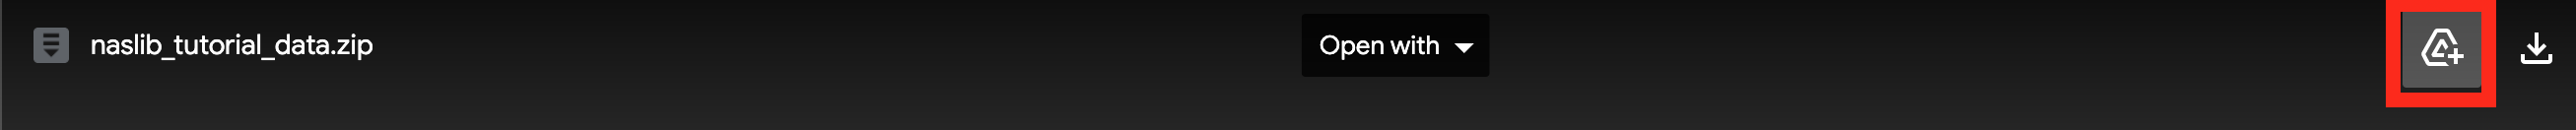
2. Uncomment the next cell and run it to mount your drive
3. Uncomment the cell after the next, fill it with the path to your shortcut (/content/drive/MyDrive/naslib_tutorial_data.zip by default), and run it to unzip the contents to the naslib data folder (/content/NASLib/naslib/data)


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !unzip /content/drive/MyDrive/naslib_tutorial_data.zip -d /content/NASLib/naslib

With that, setup is complete. We can now move on to the next section.

<a name="search_spaces"></a>
# 2. Search Spaces in NASLib 🔍
_**Note:** this part is the same as last year to give a good introduction for people who are not familiar with NASLib API. Feel free to skip to part 3 if you know the basics._

### What is NAS Search Space?
The search space is the set of all architectures which can be obtained given constraints such as the choice of operations on each edge of the graph and network topologies. We can use knowledge about the typical properties of good architectures for a task to reduce the size of the search space. However, this also introduces a human bias, which may prevent finding
novel architectural building blocks that go beyond the current human knowledge.

Consider the [NAS-Bench-201](https://arxiv.org/pdf/2001.00326.pdf) search space , for example. This search space consists of multiple stacked cells. Each cell is a directed acyclic graph, and the operation on each edge is selected from a predefined set of possible choices.

![](https://drive.google.com/uc?id=1Uw6InTaEWaE2gwgct6ztkLudEz7X3W2y)

### What is a NAS Benchmark?
A NAS benchmark consists of the true or estimated performance of architectures from a NAS Search space, each of which are evaluated on a fixed train-val-test split of the dataset and a fixed training pipeline. There are primarily two types of NAS benchmarks: *surrogate* NAS benchmarks and *tabular* NAS benchmarks.

Surrogate benchmarks use a surrogate model (eg: a neural network) to **predict the performance** of an architecture from the search space. On the other hand, tabular benchmarks query the actual performance of trained models.

### Why do we need NAS Benchmarks?

1.   Neural Architecture Search often requires large amounts of computational resources. Evaluating a single model requires training it from scratch.
2.   Reproducibility in NAS research: By having a fixed training and evaluation pipeline, NAS Benchmarks minimize confounding factors while comparing different NAS methods.

###NASLib supports multiple search spaces and benchmarks like:

1. [NAS-Bench-101](https://arxiv.org/pdf/1902.09635.pdf)
2. [NAS-Bench-201](https://arxiv.org/pdf/2001.00326.pdf)
3. [NAS-Bench-301](https://arxiv.org/pdf/2008.09777.pdf)
4. [TransNAS-Bench-101](https://arxiv.org/pdf/2105.11871.pdf)

### With a unified API, NASLib allows you to trivially perform several operations, such as:

1. Sampling random models from the search space, which you can use as **an actual PyTorch model**
2. Querying the Benchmark APIs of models for metrics such as training and validation accuracies
3. Converting between different representations of a given architecture (NASLib, for example, internally represents NAS-Bench-201 architectures using an integer 6-tuple. But you can **convert that into the string representation** used by the original authors in their repositories)
4. Mutating an architecture

In the next part of the tutorial, we walk through each of these functionalities.



In [ ]:
# Import the search space
# We begin by importing only the NAS-Bench-201 Search Space
from naslib.search_spaces import NasBench201SearchSpace

In [ ]:
# Create a new search space object.
# This object doesn't have an architecture assigned to it yet - it represents the entire search space
graph = NasBench201SearchSpace(n_classes=10) # CIFAR-10 dataset requires 10 classes

In [ ]:
# Sample a random architecture
# You can call this method only once on any instance
graph.sample_random_architecture()

# Parse the sampled architecture into a PyTorch model - this model can now be trained like a regular PyTorch model
# (This step is optional because we're not training the model from scratch)
graph.parse()

# Get the NASLib representation of the sampled model
graph.get_hash()

(1, 0, 2, 1, 4, 2)

In [ ]:
# This graph is now a NAS-Bench-201 model, which can be trained
# Forward pass some dummy data through it to see it in action

import torch

x = torch.randn(5, 3, 32, 32) # (Batch_size, Num_channels, Height, Width)

logits = graph(x)

print('Shape of the logits:', logits.shape)

Shape of the logits: torch.Size([5, 10])


In [ ]:
# Import code to convert NASLib graph to the original NAS-Bench-201 representation
from naslib.search_spaces.nasbench201.conversions import convert_naslib_to_str as convert_naslib_nb201_to_str

# Get the string representation of this model, that the original authors of NAS-Bench-201 used
convert_naslib_nb201_to_str(graph)

'|none~0|+|skip_connect~0|none~1|+|nor_conv_3x3~0|avg_pool_3x3~1|nor_conv_3x3~2|'

In [ ]:
# Mutating an architecture
# First, create a new child_graph
child_graph = NasBench201SearchSpace(n_classes=10)

# Call mutate on the child graph by passing the parent graph to it
child_graph.mutate(parent=graph)

# See the parent and child graph representations. Which edge was mutated?
print(f'Parent graph: {graph.get_hash()}')
print(f'Child graph : {child_graph.get_hash()}')

Parent graph: (1, 0, 2, 1, 4, 2)
Child graph : (1, 0, 4, 1, 4, 2)


In [ ]:
# Now, let's load the queryable tabular NAS-Bench-201 API
# This API has the training metrics of all the 15625 models in the search space
# such as train and validation accuracies/losses at every epoch
from naslib.utils import get_dataset_api
#benchmark_api = get_dataset_api(search_space='nasbench201', dataset='cifar10')

In [ ]:
# We now import all the benchmarks that we will require for this exercise
# Load all benchmarks APIs just once to avoid running out of memory
dataset_apis={}
# dataset_apis["NASBench101-cifar10"] = get_dataset_api(search_space='nasbench101', dataset='cifar10')
dataset_apis["NASBench201-cifar10"] = get_dataset_api(search_space='nasbench201', dataset='cifar10')
#dataset_apis["NASBench201-cifar100"] = get_dataset_api(search_space='nasbench201', dataset='cifar100')
#dataset_apis["NASBench201-ImageNet16-120"] = get_dataset_api(search_space='nasbench201', dataset='ImageNet16-120')
dataset_apis["NASBench301-cifar10"] = get_dataset_api(search_space='nasbench301', dataset='cifar10')

/usr/local/lib/python3.10/dist-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


1.85GiB [01:06, 28.0MiB/s]


Extracting models_1.0.zip to /content/NASLib/naslib/data/nb_models_1.0
Deleting downloaded zip at /content/NASLib/naslib/data/models_1.0.zip


In [ ]:
# With the NAS-Bench-201 API, we can now query, say, the validation performance of any NB201 model
# Without it, we would have to train the model from scratch to get this information

# First, import the Metric enum
from naslib.search_spaces.core import Metric

# Metric has, among others, these values:
# Metric.TRAIN_ACCURACY
# Metric.VAL_ACCURACY
# Metric.TRAIN_LOSS
# Metric.TEST_LOSS
# Metric.TRAIN_TIME

train_acc_parent = graph.query(metric=Metric.TRAIN_ACCURACY, dataset='cifar10', dataset_api=dataset_apis["NASBench201-cifar10"])
val_acc_parent = graph.query(metric=Metric.VAL_ACCURACY, dataset='cifar10', dataset_api=dataset_apis["NASBench201-cifar10"])

print('Performance of parent model')
print(f'Train accuracy: {train_acc_parent:.2f}%')
print(f'Validation accuracy: {val_acc_parent:.2f}%')

Performance of parent model
Train accuracy: 99.93%
Validation accuracy: 88.43%


## Task 1: NAS-Bench-301 (10 minutes)

Now that you are familiar with the operations search spaces in NASLib, we can attempt our first task. In this task, you should do the following:

1. Sample a random NAS-Bench-301 model
2. Get the NASLib representation of the model
3. Query the performance of the model
4. Mutate the model
5. Query the performance of the mutated model

All the modules you require are already imported for you.

In [ ]:
from naslib.search_spaces import NasBench301SearchSpace

########## START TODO ############

# 1. Sample a random NAS-Bench-301 (CIFAR-10) model
# 2. Get the NASLib representation of the model
# 3. Query the performance of the model
# 4. Mutate the model
# 5. Query the performance of the mutated model
# Metrics you can query in NAS-Bench-301 (which is a surrogate benchmark) are Metric.VAL_ACCURACY and Metric.TRAIN_TIME

# Write your code here

########## END TODO ##############

nb301_graph = NasBench301SearchSpace(n_classes=10)

<a name="perfpred"></a>
# 3. Performance prediction in NASLib

## The NAS process

The objective of NAS is to find a well-performing architecture for a given problem. We use the NAS optimizers - a search strategy used to explore the search space. NASLib provides a uniform API to use multiple optimizers across different benchmarks.

![](https://drive.google.com/uc?id=1e7a4LI-f7embNqUq23FwlysP6mQu63nx)

During search, we need to evaluate the performance of architectures, which often requires us to train a network up until convergence. Since this is a bottleneck of the process, we want to speed up the process. Commonly used speedup techniques are one-shot methods, evaluation on lower fidelities or **performance prediction**.

## What is a performance predictor?
A [performance predictor](https://arxiv.org/pdf/2104.01177.pdf) is generally defined as any function  (e.g. xgboost, graph convolutional networks) which predicts the final accuracy or ranking of architectures, without fully training the architectures.

The standard approach is to fully train a small number of architectures, and then use their performance as targets for a regression task (e.g. predict network accuracy, latency, ...) or ranking task (is architecture A better than architecture B in terms of accuracy?).


In this section of the tutorial, we will walk through the following:

1. Fitting XGBoost on a simple one-hot architecture encoding
2. Adding Zero-cost proxies as features to XGBoost
3. Zero cost api for fast score queries

In [ ]:
import random
from tqdm import tqdm
from naslib.search_spaces.core.query_metrics import Metric
from naslib.search_spaces.nasbench201.conversions import convert_naslib_to_str


def iterate_whole_searchspace(search_space, dataset_api, seed=None, shuffle=False):
  # Note - for nb301, this method only returns the training set architectures
  arch_iter = search_space.get_arch_iterator(dataset_api)
  if shuffle:
    arch_iter = list(arch_iter)
    rng = random if seed is None else random.Random(seed)
    rng.shuffle(arch_iter)

  for arch_str in arch_iter:
    yield arch_str


def sample_arch_dataset(search_space, dataset, dataset_api, data_size=None, arch_hashes=None, seed=None, shuffle=False):
  xdata = []
  ydata = []
  train_times = []
  arch_hashes = arch_hashes if arch_hashes is not None else set()

  # Cloning NASLib objects takes some time - this is a hack-... speedup so that
  # we can quickly get all architecture hashes and accuracies in a searchspace.
  # However, not all methods are available - e.g. you can't encode the architecture
  search_space = search_space.clone()
  search_space.instantiate_model = False
  arch_iterator = iterate_whole_searchspace(search_space, dataset_api, shuffle=shuffle, seed=seed)

  # iterate over architecture hashes
  for arch in tqdm(arch_iterator):
      if data_size is not None and len(xdata) >= data_size:
        break

      if arch in arch_hashes:
          continue

      arch_hashes.add(arch)
      search_space.set_spec(arch)

      # query metric for the current architecture hash
      accuracy = search_space.query(metric=Metric.TRAIN_ACCURACY, dataset=dataset, dataset_api=dataset_api)
      train_time = search_space.query(metric=Metric.TRAIN_TIME, dataset=dataset, dataset_api=dataset_api)

      xdata.append(arch)
      ydata.append(accuracy)
      train_times.append(train_time)

  return [xdata, ydata, train_times], arch_hashes

In [ ]:
# The free version of Google colab has <13 GB RAM available.
# NASLib objects tend to occupy a lot of memory, so we store string/tuple representations instead.
# Normally, you would work directly with a list of NASLib graphs that can be easily queried and encoded.

def encode_archs(search_space, arch_ops, encoding=None, verbose=True):
  encoded = []

  for arch_str in tqdm(arch_ops, disable=not verbose):
    arch = search_space.clone()
    arch.set_spec(arch_str)

    arch = arch.encode(encoding) if encoding is not None else arch
    encoded.append(arch)

  return encoded

In [ ]:
# NAS-Bench-201 graphs can be represented as a tuple of integers - every position corresponds to one of the edges
# 0 - skip-connection, 1 - zero, 2 - conv3x3, 3 - conv1x1, 4 - avg pooling
# Edges: [(1,2), (1,3), (1,4), (2,3), (2,4), (1,4)] ... (node_from, node_to)
i = 0
for a in iterate_whole_searchspace(NasBench201SearchSpace(), dataset_apis['NASBench201-cifar10'], shuffle=False, seed=42):
  print(a)
  i += 1
  if i > 5:
    break

(0, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 0, 1)
(0, 0, 0, 0, 0, 2)
(0, 0, 0, 0, 0, 3)
(0, 0, 0, 0, 0, 4)
(0, 0, 0, 0, 1, 0)


## XGBoost performance prediction

In [ ]:
from naslib.utils.encodings import EncodingType

seed = 2
pred_dataset = 'cifar10'
pred_api = dataset_apis['NASBench201-cifar10']
train_size = 100
test_size = 100

train_sample, train_hashes = sample_arch_dataset(NasBench201SearchSpace(), pred_dataset, pred_api, data_size=train_size, shuffle=True, seed=seed)
test_sample, _ = sample_arch_dataset(NasBench201SearchSpace(), pred_dataset, pred_api, arch_hashes=train_hashes, data_size=test_size, shuffle=True, seed=seed + 1)

100it [00:00, 2975.49it/s]
100it [00:00, 5635.84it/s]


In [ ]:
xtrain, ytrain, _ = train_sample
xtest, ytest, _ = test_sample

Before fitting a performance predictor, we need to encode the architecture to a representation that models can easily learn. The simplest encoding is onehot representation of operations concatenated with a flattened adjacency matrix.

For NB201 models, the adjacency matrix is always the same and only the operation encoding changes.

In [ ]:
enc_type = EncodingType.ADJACENCY_ONE_HOT

enc_train = encode_archs(NasBench201SearchSpace(), xtrain, encoding=enc_type)
enc_test = encode_archs(NasBench201SearchSpace(), xtest, encoding=enc_type)

100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


In [ ]:
print(xtrain[0])
str(enc_train[0])

(1, 3, 3, 0, 2, 0)


'[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]'

NASLib implements several [performance predictors](https://github.com/automl/NASLib/tree/Develop/naslib/predictors), ranging from simple models like Random forest or XGBoost to predictors based on graph neural networks.
All predictors use the same fit-query api and allow using additional information, such as zero cost proxies or unlabeled data for semi-supervised predictors. This enables us to [fairly evaluate](https://openreview.net/forum?id=6RB77-6-_oI) different predictors on available search spaces.

In this notebook, we will use XGBoost, as it can easily combine zero cost proxies and architecture encoding.

In [ ]:
from naslib.predictors.trees.xgb import XGBoost

model = XGBoost()
model.fit(enc_train, ytrain)
res = model.query(enc_test)

Although performance prediction is often handled as a regression task, correct predicted ranking of architectures is usually more important - during black-box optimization in NAS, we select the best performing networks regardless of their actual performance.

To evaluate performance predictors, we use rank-based metrics
like Kendall tau (measures if pairs of architectures are ordered correctly)
or Spearman's rank correlation.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from naslib.utils import compute_scores  # computes more metrics than just correlation
from scipy.stats import kendalltau, spearmanr
sns.set()


def evaluate_predictions(y_true, y_pred, plot=False, plot_func=None, title=None):
  res = {}
  res['kendalltau'] = kendalltau(y_true, y_pred)[0]
  res['spearmanr'] = spearmanr(y_true, y_pred)[0]

  if plot:
    plt.figure()
    plt.scatter(y_true, y_pred, marker='.')

    # additional graph aesthetics
    if plot_func is not None:
      plot_func(res)

    tautitle = f"tau: {res['kendalltau'].round(2)}"
    if title is not None:
      plt.title(title + f" - {tautitle}")
    else:
      plt.title(tautitle)

    plt.show()

  return res

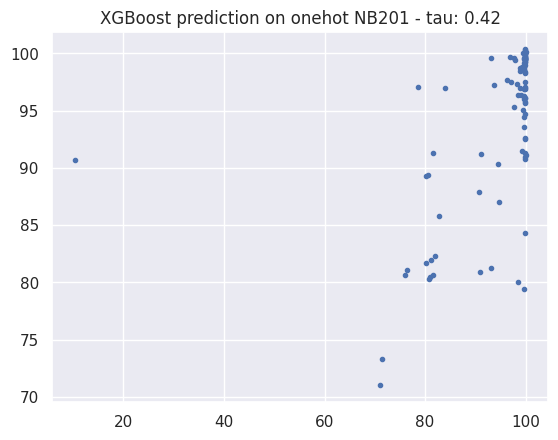


 {'kendalltau': 0.4196148187047212, 'spearmanr': 0.5923254246600577}


In [ ]:
metrics = evaluate_predictions(ytest, res, plot=True, title="XGBoost prediction on onehot NB201")
print("\n", metrics)

Save all metrics across experiments in the following dict:

In [ ]:
expe_metrics = {}
expe_metrics['XGBoost_onehot'] = metrics

<a name="zcps"></a>
## Zero Cost Proxies

Zero Cost proxies allow us to *rank* models using only a single forward and backward pass of a minibatch of data. They require much less time and compute to score models - most proxies take a few seconds to compute (~2 seconds on cifar10).
As so, they can be used as a cheap *proxy* to **speed up black-box optimizers**. Additionally, they can be used as architectural features that enable transfer across different search spaces, as they **don't depend on architectural encoding**.

The main disadvantage of proxies is that their performance is not consistent - a proxy with a great correlation on a given search space and dataset may perform poorly on a different searchspace and dataset. Notably, all proxies except `flops` and `params` have low scores on most DARTS problems. A possible solution would be to use combinations of proxies or to determine what proxies work for which tasks.
You can learn more about this problem [here](https://iclr-blog-track.github.io/2022/03/25/zero-cost-proxies/).

In this section, we look how we can use the Zero Cost proxies available in NASLib ( Table 1, [NAS-Bench-Suite-Zero:
Accelerating Research on Zero Cost Proxies](https://arxiv.org/pdf/2210.03230.pdf)) to *score* a model. Intuitively, the higher the score of a model, the better we expect the model to perform (this isn't always true, though - there are cases where the scores are anti-correlated with the validation performance).

Then, we will use the proxies directly in performance prediction as additional features.

In [ ]:
# Imports used throughout this section
from naslib.predictors import ZeroCost
from naslib.search_spaces import NasBench201SearchSpace
from naslib.utils import get_train_val_loaders, get_project_root
from fvcore.common.config import CfgNode
from tqdm import tqdm

In [ ]:
# Create configs required for get_train_val_loaders
config_dict = {
    'dataset': 'cifar10', # Dataset to loader: can be cifar10, cifar100, ImageNet16-120
    'data': str(get_project_root()) + '/data', # path to naslib/data where cifar is saved
    'search': {
        'seed': 9001, # Seed to use in the train, validation and test dataloaders
        'train_portion': 0.7, # Portion of train dataset to use as train dataset. The rest is used as validation dataset.
        'batch_size': 32, # batch size of the dataloaders
    }
}
config = CfgNode(config_dict)

# Get the dataloaders
train_loader, val_loader, test_loader, train_transform, valid_transform = get_train_val_loaders(config)

# Sample a random NB201 graph and instantiate it
graph = NasBench201SearchSpace()
graph.sample_random_architecture()
graph.parse()

# Instantiate the ZeroCost predictor
# The Zero Cost predictors can be any of the following:
# {'epe_nas', 'fisher', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'plain', 'snip', 'synflow', 'zen', 'flops', 'params'}

zc_proxy = 'plain'
zc_predictor = ZeroCost(method_type=zc_proxy)
score = zc_predictor.query(graph=graph, dataloader=train_loader)

print(f'Score of model for Zero Cost predictor {zc_proxy}: {score}')


100%|██████████| 170498071/170498071 [00:05<00:00, 31256782.61it/s]


Extracting /content/NASLib/naslib/data/cifar-10-python.tar.gz to /content/NASLib/naslib/data
Files already downloaded and verified
Score of model for Zero Cost predictor plain: 0.06469706445932388


Let's now try scoring the same model with all the Zero Cost proxies. Remember that it only makes sense to make comparisons between the scores of different models of a given proxy.

In [ ]:
# Instantiate the ZeroCost predictor
# The Zero Cost predictors can be any of the following:
zc_proxies = ['epe_nas', 'fisher', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'plain', 'snip', 'synflow', 'zen', 'flops', 'params']

print('Scores of the model')
for zc_proxy in zc_proxies:
    zc_predictor = ZeroCost(method_type=zc_proxy)
    score = zc_predictor.query(graph=graph, dataloader=train_loader)
    print(f'{zc_proxy}: {score:3f}')

Scores of the model
epe_nas: 160.043414


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


fisher: 0.015672
grad_norm: 5.130321
grasp: -0.968150
jacov: -643.448648
l2_norm: 78.745659
nwot: 308.941681
plain: 0.104056
snip: 7.367403
synflow: 25.189593
zen: 24.938808
flops: 14.886592
params: 0.101306


Some proxies explained:
- params - just the number of parameters in the networks
- grad_norm - average norm of gradients in the network

...but it gets more complex:
- jacov - covariance of the Jacobian matrices in on minibatch
- epe_nas - intra- and inter-class correlations of the prediction Jacobian matrices

<a name="zcpperfpred"></a>
### a) Zero cost proxies for performance prediction
In this section, we will evaluate a zero cost proxy for our sampled architectures and use them in prediction alongside the onehot features.

In [ ]:
def eval_zcp(model, zc_name, data_loader):
  model = encode_archs(NasBench201SearchSpace(), [model], verbose=False)[0]
  model.parse()
  zc_pred = ZeroCost(method_type=zc_name)
  res = zc_pred.query(graph=model, dataloader=data_loader)

  return {zc_name: res}

In [ ]:
# NOTE - this may take a lot of time ... ~ 5 minutes
# ...you can skip to the next part (spoilers - speedup)

zcp_name = 'synflow'
zc_only = False

# train and query expect different ZCP formats for some reason
zcp_train = {'zero_cost_scores': [eval_zcp(t_arch, zcp_name, train_loader) for t_arch in tqdm(xtrain)]}
zcp_test = [{'zero_cost_scores': eval_zcp(t_arch, zcp_name, train_loader)} for t_arch in tqdm(xtest)]

100%|██████████| 100/100 [02:57<00:00,  1.78s/it]


First, evaluate the correlation of the chosen proxy with ground truth accuracies.

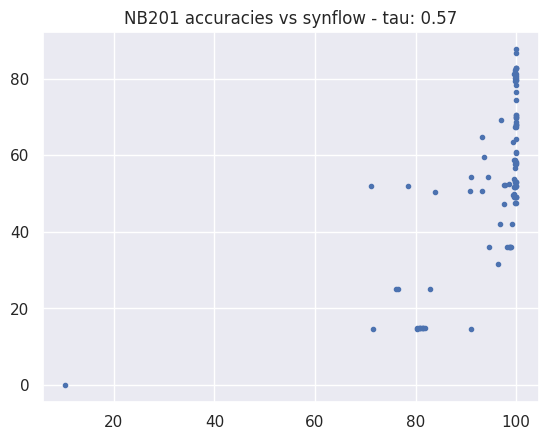


 {'kendalltau': 0.5736019081376464, 'spearmanr': 0.7465972170602222}


In [ ]:
zcp_pred = [s['zero_cost_scores'][zcp_name] for s in zcp_test]
metrics = evaluate_predictions(ytest, zcp_pred, plot=True,
                               title=f"NB201 accuracies vs {zcp_name}")
print("\n", metrics)

In [ ]:
# set to True to fit only on proxy score(s) and not on architecture encoding
zc_only = False

zcp_model = XGBoost(zc=True, zc_only=zc_only)
zcp_model.set_pre_computations(xtrain_zc_info=zcp_train)  # it is also possible to pass a numpy array to XGBoost fit

In [ ]:
# even when using zc_only, you must pass a list to both fit and query (it can be empty)
zcp_model.fit(enc_train, ytrain)
res = zcp_model.query(enc_test, info=zcp_test)

As you can see, combining onehot features with a proxy is only slightly better than just using the proxy. However, this is not always the case - for some tasks, the encoding seems to be important.

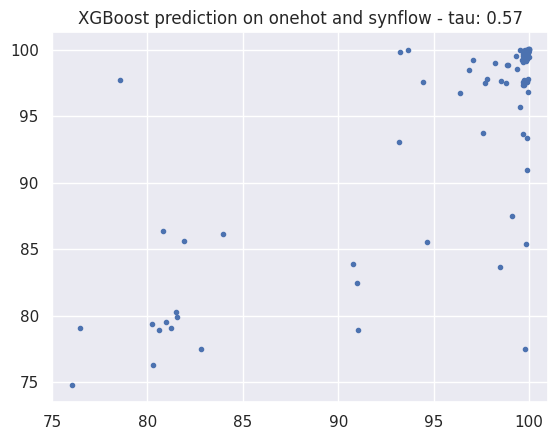


 {'kendalltau': 0.5675234703968731, 'spearmanr': 0.7564635061252603}


In [ ]:
metrics = evaluate_predictions(ytest, res, plot=True, plot_func=lambda x: plt.xlim(75, 101),
                               title=f"XGBoost prediction on {'' if zc_only else 'onehot and '}{zcp_name}")
print("\n", metrics)

In [ ]:
expe_metrics[f"XGBoost{'' if zc_only else '_onehot'}_{zcp_name}"] = metrics
expe_metrics

{'XGBoost_onehot': {'kendalltau': 0.4196148187047212,
  'spearmanr': 0.5923254246600577},
 'XGBoost_onehot_synflow': {'kendalltau': 0.5675234703968731,
  'spearmanr': 0.7564635061252603}}

### b) Zero Cost Proxy Benchmarks

Just like NAS-Benchmark APIs, NASLib contains Zero Cost Benchmark APIs in order to speed-up NAS research even further. The Zero Cost Benchmark API (or [NAS-Bench-Suite Zero](https://openreview.net/forum?id=yWhuIjIjH8k) [2]) lets you instantly query the Zero Cost proxy scores for a given model and search space.

For example, if your black-box optimizer uses Zero Cost proxies, you could use the benchmark to run the experiments much faster by simply querying them for the scores instead of explicitly calling the Zero Cost Predictor.
Another good use-case is analysing the zero-cost proxies across all available networks, and identifying network properties with high scores.

We have already downloaded the Zero Cost Benchmark API for NAS-Bench-201, which has the scores for all 15625 models evaluated for all three datasets (CIFAR-10, CIFAR-100 and ImageNet16-120) using all 13 Zero Cost proxies.

[2] Krishnakumar et al. *NAS-Bench-Suite-Zero: Accelerating Research on Zero Cost Proxies*. Neurips 2022.


In [ ]:
from naslib.utils import get_zc_benchmark_api

# Load the Zero Cost Benchmark API for NAS-Bench-201 CIFAR-10
zc_api = get_zc_benchmark_api('nasbench201', 'cifar10')

# Use the Zero Cost Benchmark to get the score for the model for a particular ZC proxy
pred = 'grasp'
spec = xtrain[0]

# The Zero Cost Benchmarks are simply dictionaries, and the key used to query a model
# is sim the stringified NASLib representation of that model
score = zc_api[str(spec)][pred]['score']
time_to_compute = zc_api[str(spec)][pred]['time']

print(f'All the data available in the Zero Cost benchmark for model {spec}: ')
print(zc_api[str(spec)][pred])
print(f'Score of model with spec {spec} for Zero Cost proxies {pred}: {score}')
print(f'Time taken to compute the score for the model: {time_to_compute:.2f}s')

All the data available in the Zero Cost benchmark for model (1, 3, 3, 0, 2, 0): 
{'score': 2.651945114135742, 'time': 2.7753620259463787}
Score of model with spec (1, 3, 3, 0, 2, 0) for Zero Cost proxies grasp: 2.651945114135742
Time taken to compute the score for the model: 2.78s


In [ ]:
# using the zc benchmark api, we can easily get all available proxies as well as validation accuracy
def query_models(arch_data, api):
  zc = []
  target = []

  for arch in arch_data:
    entry = api[str(arch)]
    zc.append({z: e['score'] for z, e in entry.items() if z != 'id' and z != 'val_accuracy'})
    target.append(entry['val_accuracy'])

  return zc, target

## TASK 2 (10 min)
Solve 2a first, 2b is a bonus task

## TASK 2a: XGBoost and all proxies
Using `query_models`, get all available proxies corresponding to `xtrain` and `xtest` and use them in XGBoost prediction. You can compare using them with onehot features or without them, or using only *a* subset of the proxies.

Look at the [previous examples](#zcpperfpred) for the correct argument format:
- required format for train is `{'zero_cost_scores': score_list}`, where
`score_list` contains entries `{'synflow': 25.0, 'nwot': 486.0, ...}`
- required test format is `[{'zero_cost_scores: {'synflow': 25.0 ...} ...]`

In [ ]:
########## START TODO ############

# 1. Query train and test models, hold to the given format
# 2. Create a XGBoost model and call `set_pre_computations()`
# 3. Fit and predict using the proxies, evaluate and plot the results.
# 4. Save the results to `expe_metrics` dict and try a different combination (e.g. zc_only)
#    - or go to 2b if you don't want to run more experiments

# Write your code here

########## END TODO ##############

## TASK 2b: Analysis of networks and proxies
Look at top scored networks (e.g. top 10 scored by synflow) and try to see some common property - what ops do they contain and on what positions?

The NB201 architectures have the following format:
- 0 - skip-connection, 1 - zero, 2 - conv3x3, 3 - conv1x1, 4 - avg pooling
- Edges: `[(1,2), (1,3), (1,4), (2,3), (2,4), (1,4)]` ... (node_from, node_to)

In [ ]:
########## START TODO ############

# 1. Using zc_api, get all network encoding and scores of 1 proxy (e.g. synflow)
# 2. Sort network encodings by the proxy score, try to explain what networks have high scores.

# Write your code here

########## END TODO ##############

<a name="exte"></a>
# 4. Extensions
In this section and in the following section 5., we will reuse the same datasets and api defined in the previous sections on more advanced tasks:
- robustness
- implementing a new proxy
- (s. 5.) transfer to other datasets/search spaces

If you want to dig deep into one of these tasks, feel free to skip and work on your own (especially if the time estimate was too optimistic). Every task has suggestions for extensions that you can explore.

## Robustness tasks
In this exercise, you will fit a performance predictor on a different target - namely robustness tasks. The
[Neural Architecture Design and Robustness](https://steffen-jung.github.io/robustness/) is a dataset of NB201 models evaluated on various robustness tasks and different perturbation magnitude values (eps).

You also learn here how to integrate NASLib and other api - these can use different architecture encodings, and you can use NASLib conversion functions to unify them.

In [ ]:
!gdown 1D3oN_VDdibKGcmbUJm6e6slXcPoN8yty  -q
!unzip -qo robustness-data.zip
!git clone https://github.com/steffen-jung/robustness-dataset -q

In [ ]:
import sys
if 'robustness-dataset' not in sys.path:
  sys.path.append('robustness-dataset')

In [ ]:
from robustness_dataset import RobustnessDataset

data = RobustnessDataset(path="robustness-data")

In [ ]:
# The available robustness tasks
data.keys_adv

['aa_apgd-ce@Linf', 'aa_square@Linf', 'fgsm@Linf', 'pgd@Linf']

In [ ]:
# Different perturbation magnitudes of the attack
data.meta["epsilons"]['fgsm@Linf']

[0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 255.0]

In [ ]:
# Accuracies per each eps value of the attack
res = data.query(data=data.data_cifar10, key='fgsm@Linf', measure='accuracy')
res['cifar10']['fgsm@Linf']['accuracy']['0']

[0.806, 0.582, 0.35, 0.13, 0.066, 0.046, 0.038, 0.038, 0.042, 0.048, 0.102]

In [ ]:
# In the dataset, the string representation of NB201 is used
data.meta['ids']['0']

{'nb201-string': '|avg_pool_3x3~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_1x1~0|skip_connect~1|skip_connect~2|',
 'isomorph': '0'}

In [ ]:
from naslib.search_spaces.nasbench201.conversions import convert_str_to_op_indices

# NASLib-to-str_repre map - to connect the two APIs
spec_to_ids_map = {}

for str_repre in data.meta['ids'].values():
  spec = convert_str_to_op_indices(str_repre['nb201-string'])
  spec_to_ids_map[spec] = str_repre['isomorph']

In [ ]:
# Query robust metrics of a NASLib graph
graph = NasBench201SearchSpace()
graph.sample_random_architecture()
robustness_id = spec_to_ids_map[graph.get_hash()]

print(graph.get_hash())
print(graph.query(Metric.VAL_ACCURACY, 'cifar10', dataset_api=dataset_apis['NASBench201-cifar10']))
print(res['cifar10']['fgsm@Linf']['accuracy'][robustness_id])

(2, 0, 0, 3, 0, 0)
85.57
[0.827, 0.505, 0.253, 0.105, 0.074, 0.06, 0.056, 0.054, 0.054, 0.058, 0.093]


## TASKS 3 and 4 (15 min)

## TASK 3: Predict robustness!
Run performance prediction on a chosen robustness task.

This task was approached in this [recent paper](https://arxiv.org/pdf/2307.09365.pdf).


In [ ]:
########## START TODO ############

# 1. Choose one of the robustness tasks and a value of epsilon.
# 2. Get target accuracy that corresponds to xtrain and xtest.
# 3. Fit a performance predictor just like in the previous tasks.
# 4. Compare the results with clean accuracy.

# Optionally:
# 5a. compare results on all available epsilon values, plot them.
# 5b. compare results across all tasks for one eps value.

# Write your code here

########## END TODO ##############

## TASK 4: Write your own proxy!
The following code integrates a new proxy function directly into NASLib.

- @measure registeres the `"weight_std"` function that can be used to score networks (a simple dummy function[text odkazu](https://)).
- In the code, `get_layer_metric_array(net, func)` computes func of every linear/conv layer of net, `mode` can be in our case anything but `channel`
- Look at available [proxy code](https://github.com/automl/NASLib/tree/Develop/naslib/predictors/utils/pruners/measures) for inspiration

In [ ]:
from naslib.predictors.utils.pruners.measures import measure
from naslib.predictors.utils.pruners.p_utils import get_layer_metric_array


# copy net should be True if you modify the network
@measure("weight_std", copy_net=False, mode="param")
def get_l2_norm_array(net, inputs, targets, mode, split_data=1, **kwargs):
    return get_layer_metric_array(net, lambda l: l.weight.std(), mode=mode)

In [ ]:
from naslib.predictors.utils.pruners.measures import _measure_impls, available_measures

def delete_measure(name):
  del _measure_impls[name]
  for i in range(len(available_measures)):
    if available_measures[i] == name:
      available_measures.pop(i)
      break

In [ ]:
# Once registering a proxy with @measure, it can't be registered again.
# Use the following function to delete it.

#delete_measure('weight_std')

In [ ]:
new_proxy = ZeroCost(method_type='weight_std')
graph = NasBench201SearchSpace()
graph.sample_random_architecture()
graph.parse()

score = new_proxy.query(graph=graph, dataloader=train_loader)
score

1.105041265487671

In [ ]:
########## START TODO ############

# 1. Think of some metric that could capture network performance.
# 2. Evaluate the proxy on a graph to verify it runs. In case of bugs, run delete_measure(proxname) and then modify the function.
# 3. Once you have a proxy, evaluate it for all train and test networks and compute correlation metrics.
# 4. You can also compute correlations with other available proxies -
#    a high correlation could also mean a bias towards an existing proxy, e.g. params.

# Write your code here

########## END TODO ##############

<a name="transfer"></a>
# 5. Transfer - performance prediction on an unseen task

Zero cost proxies can be used as search space agnostic features and used in transfer learning. In this part, we will train a MLP performance predictor on cifar10, and then transfer to ImageNet.

Recent work employing ZCP transfer - [MultiPredict](https://openreview.net/forum?id=14U6uzrh-wr).

### MLP network code

In [ ]:
# TODO credit eaglu
# try both batchnorm and layer norm

import torch
import torch.nn as nn
import math

class MLP(nn.Module):
  def __init__(self, n_inputs, n_layers=2, n_hidden=32, dropout=0, use_batchnorm=False):

    super().__init__()

    norm = nn.BatchNorm if use_batchnorm else nn.LayerNorm

    self.mlp = nn.ModuleList([nn.Linear(n_inputs if i == 0 else n_hidden, n_hidden) for i in range(n_layers)])
    self.bn = nn.ModuleList([norm(n_hidden) for i in range(n_layers)])
    self.relu = nn.ModuleList([nn.ReLU() for i in range(n_layers)])
    self.fc = nn.Linear(n_hidden, 1)
    self.dropout = nn.ModuleList([nn.Dropout(dropout) for i in range(n_layers)])

  def forward(self, x):
    x = self.relu[0](self.bn[0](self.mlp[0](x)))
    x = self.dropout[0](x)

    for i in range(1, len(self.mlp)):
      x = self.relu[i](self.bn[i](self.mlp[i](x)))
      x = self.dropout[i](x)

    return self.fc(x)

  def freeze_weights(self, value=False, reset_last=True):
    for lin in self.mlp:
      lin.requires_grad = value
    for bn in self.bn:
      bn.requires_grad = value

    self.reset_last()

  def reset_last(self):
    self.fc.reset_parameters()

### MLP Predictor code

In [ ]:
import numpy as np
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from naslib.predictors.trees.base_tree_class import BaseTree
from naslib.utils import AverageMeterGroup


class MLPPredictor(BaseTree):
  def __init__(self, model=None, model_kwargs=None, encoding_type=None, zc=False, zc_only=False):
    super().__init__(encoding_type=encoding_type, zc=zc, zc_only=zc_only)
    self.model = model
    self.model_kwargs = model_kwargs if model_kwargs is not None else {}
    self.n_inputs = None

  def get_transferable_model(self, freeze=True):
    if self.model is None:
      raise ValueError("Must call fit before a model can be transferred.")

    model = MLP(self.n_inputs, **self.model_kwargs)
    model.load_state_dict(self.model.state_dict())
    if freeze:
      model.freeze_weights()
    return model

  def fit(self, xtrain, ytrain, train_info=None, epochs=500, lr=1e-4, loss=None, verbose=0, weight_decay=5.0e-4, device=None, batch_size=32, print_freq=100):
    # normalize accuracies
    self.mean = np.mean(ytrain)
    self.std = np.std(ytrain)

    if isinstance(xtrain[0], nn.Module):
      xtrain = np.array([arch.encode(encoding_type=self.encoding_type) for arch in xtrain])
    if self.zc:
      if self.zc_only:
          xtrain = self.zc_features
      else:
          xtrain = [[*x, *zc_scores] for x, zc_scores in zip (xtrain, self.zc_features)]

      xtrain = np.array(xtrain)
      ytrain = (np.array(ytrain) - self.mean) / self.std

    if self.model is None:
      self.n_inputs = xtrain.shape[1]
      self.model = MLP(self.n_inputs, **self.model_kwargs)

    self.model.to(device)

    criterion = loss.to(device) if loss is not None else nn.MSELoss().to(device)
    optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0)

    X_tensor = torch.FloatTensor(xtrain).to(device)
    y_tensor = torch.FloatTensor(ytrain).to(device)
    train_data = TensorDataset(X_tensor, y_tensor)
    data_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=False,
        pin_memory=False,
    )

    self.model.train()

    for e in range(epochs):
      meters = AverageMeterGroup()
      for b, batch in enumerate(data_loader):
        optimizer.zero_grad()
        input = batch[0].to(device)
        target = batch[1].to(device)
        prediction = self.model(input).view(-1)

        loss_fn = criterion(prediction, target)
        loss_fn.backward()
        optimizer.step()

        meters.update(
            {"loss": loss_fn.item()}, n=target.size(0)
        )

      scheduler.step()

      if verbose and e % print_freq == 0:
          print("Epoch {}, {}".format(e, meters["loss"]))

  def query(self, xtest, info=None, eval_batch_size=None, device=None):
      if isinstance(xtest[0], nn.Module):
        xtest = np.array([arch.encode(encoding_type=self.encoding_type) for arch in xtest])
      if self.zc:
        zc_scores = [self.create_zc_feature_vector(data['zero_cost_scores']) for data in info]
        if self.zc_only:
          xtest = zc_scores
        else:
          xtest = [[*x, *zc] for x, zc in zip(xtest, zc_scores)]
        xtest = np.array(xtest)

      X_tensor = torch.FloatTensor(xtest).to(device)
      test_data = TensorDataset(X_tensor)

      eval_batch_size = len(xtest) if eval_batch_size is None else eval_batch_size
      test_data_loader = DataLoader(
          test_data, batch_size=eval_batch_size, pin_memory=False
      )

      self.model.eval()
      pred = []
      with torch.no_grad():
          for _, batch in enumerate(test_data_loader):
              prediction = self.model(batch[0].to(device)).view(-1)
              pred.append(prediction.cpu().numpy())

      pred = np.concatenate(pred)
      return np.squeeze(pred) * self.std + self.mean

## Train MLP
First, train the MLP predictor on cifar10 just like XGBoost before.

In [ ]:
zc_only = False

# We reuse the queried proxy values from Task 2a
# If you did not do the task, query the zc_api (look below for ImageNet examples
# for a hint).
mlp_pred = MLPPredictor(zc=True, zc_only=zc_only)
mlp_pred.set_pre_computations(xtrain_zc_info=zcp_train_query)
mlp_pred.fit(enc_train, ytrain, verbose=True, epochs=800)

Epoch 0, loss 1.279467 (1.876176)
Epoch 100, loss 0.048737 (0.310955)
Epoch 200, loss 0.003437 (0.243542)
Epoch 300, loss 0.014324 (0.229517)
Epoch 400, loss 0.045835 (0.222180)
Epoch 500, loss 0.006818 (0.218166)
Epoch 600, loss 0.014593 (0.216506)
Epoch 700, loss 0.171321 (0.215684)


In [ ]:
res = mlp_pred.query(enc_test, info=zcp_test_query)

In [ ]:
metrics = evaluate_predictions(ytest, res, plot=False,
                               title=f"MLP prediction on {'' if zc_only else 'onehot and '}all proxies")
print("\n", metrics)


 {'kendalltau': 0.6315496812663526, 'spearmanr': 0.801816028305609}


In [ ]:
expe_metrics[f"MLP{'' if zc_only else '_onehot'}_all-proxies"] = metrics
expe_metrics

{'XGBoost_onehot': {'kendalltau': 0.4196148187047212,
  'spearmanr': 0.5923254246600577},
 'XGBoost_onehot_synflow': {'kendalltau': 0.5675234703968731,
  'spearmanr': 0.7564635061252603},
 'XGBoost_onehot_all-proxies': {'kendalltau': 0.6700464536245839,
  'spearmanr': 0.8408730898842394},
 'XGBoost_all-proxies': {'kendalltau': 0.6765301205480754,
  'spearmanr': 0.8456922079616271},
 'MLP_all-proxies': {'kendalltau': 0.6315496812663526,
  'spearmanr': 0.801816028305609}}

In the same way, you can train on ImageNet

In [ ]:
zc_api_img = get_zc_benchmark_api('nasbench201', 'ImageNet16-120')

In [ ]:
img_zcs_train, img_ytrain = query_models(xtrain, zc_api_img)
img_zcs_test, img_ytest = query_models(xtest, zc_api_img)

In [ ]:
img_mlp_pred = MLPPredictor(zc=True)
img_mlp_pred.set_pre_computations(xtrain_zc_info={'zero_cost_scores': img_zcs_train})
img_mlp_pred.fit(enc_train, img_ytrain, verbose=True, epochs=800)

Epoch 0, loss 0.341579 (1.091560)
Epoch 100, loss 0.134246 (0.190684)
Epoch 200, loss 0.399663 (0.148886)
Epoch 300, loss 0.119094 (0.122508)
Epoch 400, loss 0.190656 (0.104362)
Epoch 500, loss 0.070478 (0.091424)
Epoch 600, loss 0.050931 (0.082913)
Epoch 700, loss 0.053259 (0.080002)


In [ ]:
res = img_mlp_pred.query(enc_test, info=[{'zero_cost_scores': v} for v in img_zcs_test])

In [ ]:
metrics = evaluate_predictions(img_ytest, res, plot=False,
                               title=f"MLP prediction on {'' if zc_only else 'onehot and '}all proxies")
print("\n", metrics)


 {'kendalltau': 0.6701687073290559, 'spearmanr': 0.8527958379751494}


## Do the tranfer!

We will try a cifar predictor again just to have the code here (and avoid scrolling). We will use only the proxies so that the model is more general.

In [ ]:
zc_only = True

cifar_pred = MLPPredictor(zc=True, zc_only=zc_only)
cifar_pred.set_pre_computations(xtrain_zc_info=zcp_train_query)
cifar_pred.fit(enc_train, ytrain, verbose=True, epochs=800)

Epoch 0, loss 0.780922 (1.556631)
Epoch 100, loss 0.038344 (0.475629)
Epoch 200, loss 0.156101 (0.288899)
Epoch 300, loss 0.240659 (0.249819)
Epoch 400, loss 0.012909 (0.235773)
Epoch 500, loss 0.042424 (0.229011)
Epoch 600, loss 0.016789 (0.225917)
Epoch 700, loss 0.013939 (0.224755)


In [ ]:
res = cifar_pred.query(enc_test, info=zcp_test_query)
evaluate_predictions(ytest, res, plot=False)

{'kendalltau': 0.6542425154985732, 'spearmanr': 0.8220767289647142}

If you evaluate the predictor on ImageNet zero cost proxy values, you can see that the correlation is already pretty high!

In [ ]:
res = cifar_pred.query(enc_test, info=[{'zero_cost_scores': v} for v in img_zcs_test])
evaluate_predictions(img_ytest, res, plot=False)

{'kendalltau': 0.5638953458412406, 'spearmanr': 0.7307792702681265}

It is even higher when using cifar10 proxy values and ImageNet targets. This is because cifar10 and ImageNet are similar tasks, however, we won't be so lucky for other tasks.

In [ ]:
res = cifar_pred.query(enc_test, info=zcp_test_query)
evaluate_predictions(img_ytest, res, plot=False)

{'kendalltau': 0.5937973562978882, 'spearmanr': 0.7775240849842525}

Now, we will clone the model trained on 100 cifar10 networks and use it to train on only 20 ImageNet labeled networks.

In [ ]:
freeze = False
imgsize = 20
transfer = True

print(f"Using {imgsize} architecture samples for ImageNet")
print("--------------------------------------------")
for transfer in [False, True]:
  cifar_model = cifar_pred.get_transferable_model(freeze=freeze)
  img_transfer = MLPPredictor(model=cifar_model if transfer else None, zc=True, zc_only=zc_only)
  img_transfer.set_pre_computations(xtrain_zc_info={'zero_cost_scores': img_zcs_train[:imgsize]})
  img_transfer.fit(enc_train[:imgsize], img_ytrain[:imgsize], verbose=False, epochs=800)

  res = img_transfer.query(enc_test, info=[{'zero_cost_scores': v} for v in img_zcs_test])
  print("Transfer" if transfer else "From scratch")
  print(evaluate_predictions(img_ytest, res, plot=False))
  print()

Using 20 architecture samples for ImageNet
--------------------------------------------
From scratch
{'kendalltau': 0.6071320366366636, 'spearmanr': 0.7873770998448275}

Transfer
{'kendalltau': 0.6204667169754389, 'spearmanr': 0.8057029874113293}



## TASK 5: Transfer level 2 (90 min - current min)
Choose any task that you find interesting
- transfer to robustness tasks
- transfer to nb301 (use only proxies as the onehot encoding is different)
- train on more cifar10 networks (e.g. 1000) and see if it improves the transfer
- (harder) modify the MLP code so that only the ZCP part is transferred, but then after the transfer, we add the onehot encoding just before the final linear layer
    - This enables transfer to e.g. nb301 while leveraging onehot features
    - No idea if it helps, I had this idea while creating this notebook :)

In [ ]:
########## START TODO ############

# 1. Do the transfer

# Write your code here

########## END TODO ##############

# Thanks for doing the NASLib hands-on!

Enjoy the rest of the fall school and [reach out](https://gabikadlecova.github.io) if you have some questions or if you have an interesting idea!

If you have time and energy ☕, please fill out a short [feedback form](https://forms.gle/qsNsWB8e2cR4DfMf6).